In [158]:
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d

# 计算IVIX

In [159]:
token = 'e44d0c1b455757bd12b08bd16256539e784854bbeb6deae4349f9c03'
pro = ts.pro_api(token)
# 所有期权合约信息
opt_basic = pro.opt_basic(exchange="SSE")

## 各种计算

In [160]:
# 获取无风险利率，用SHIBOR
def get_rf(trade_date):
    shibor = pro.shibor(start_date=trade_date, end_date=trade_date)
    rf = pd.DataFrame()
    rf['tau'] = [1,7,14,30,180,270,365]
    rf['rate'] = shibor.iloc[0,1:].reset_index(drop=True)
    interp = interp1d(rf['tau'],rf['rate'],kind="linear",fill_value="extrapolate")
    return interp

In [161]:
# 获取期权数据，并分成近月和次近月两份
def opt_data(trade_date):
    opt_price = pro.opt_daily(trade_date=trade_date,exchange="SSE")
    opt_price_temp = opt_price[opt_price['exchange'] == 'SSE'].reset_index(drop=True)
    opt_basic_temp = opt_basic[(opt_basic['ts_code'].isin(opt_price_temp['ts_code']))&(opt_basic['opt_code']=='OP510050.SH')][
        ['ts_code','call_put','maturity_date','exercise_price']
    ].reset_index(drop=True)
    
    opt_price = pd.merge(opt_price_temp,opt_basic_temp,how='inner')
    opt_price['tau'] = (pd.to_datetime(opt_price['maturity_date']) - pd.to_datetime(opt_price['trade_date'])).apply(lambda x:x.days)
    opt_price = opt_price.sort_values(by=['tau','exercise_price']).reset_index(drop=True)
    opt_price = opt_price[opt_price['tau']>7].reset_index(drop=True)
    opt_near = opt_price[opt_price['tau'] == opt_price['tau'].drop_duplicates().nsmallest(2).tolist()[0] ].reset_index(drop=True)
    opt_2near = opt_price[opt_price['tau'] == opt_price['tau'].drop_duplicates().nsmallest(2).tolist()[1] ].reset_index(drop=True)
    return opt_near,opt_2near

In [162]:
# 根据CBOE公式计算sigma
def cal_sigma(opt_df):
    opt_df_call = opt_df[opt_df['call_put'] == "C"].sort_values(by=['exercise_price']).reset_index(drop=True)
    opt_df_put = opt_df[opt_df['call_put'] == "P"].sort_values(by=['exercise_price']).reset_index(drop=True)
    
    opt_df_call = opt_df_call[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'call_close'})
    opt_df_put = opt_df_put[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'put_close'})
    
    opt_df_merge = pd.merge(opt_df_call,opt_df_put,on=['tau','exercise_price'])
    opt_df_merge['diff_close'] = abs(opt_df_merge['call_close'] - opt_df_merge['put_close'])
    S = opt_df_merge[opt_df_merge['diff_close'] == opt_df_merge['diff_close'].min()]['exercise_price'].iloc[0]
    
    tau = opt_df_merge['tau'].unique().tolist()[0]
    opt_df_merge['R'] = interp(tau)/100
    opt_df_merge['F'] = S + np.exp( opt_df_merge['R'] * (tau/365) )*(opt_df_merge[opt_df_merge['exercise_price'] == S]['call_close'] - opt_df_merge[opt_df_merge['exercise_price'] == S]['put_close']).iloc[0]#.mean()
    opt_df_merge['F - Ki'] = opt_df_merge['F'] - opt_df_merge['exercise_price']
    
    try:
        opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'][opt_df_merge['F - Ki']>0].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]
    except Exception:
        opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]

    opt_df_merge['PK'] = opt_df_merge.apply(lambda row: row['call_close'] if row['exercise_price']>row['K0'] else (row['put_close'] if row['exercise_price']<row['K0'] else (row['call_close']+row['put_close'])/2 ),axis=1)
    opt_df_merge['K_i+1'] = opt_df_merge['exercise_price'].shift(-1).fillna(opt_df_merge['exercise_price'].iloc[-1])
    opt_df_merge['K_i-1'] = opt_df_merge['exercise_price'].shift(1).fillna(opt_df_merge['exercise_price'].iloc[0])
    opt_df_merge['delta_K'] = (opt_df_merge['K_i+1'] - opt_df_merge['K_i-1'])/2
    opt_df_merge = opt_df_merge.dropna().reset_index(drop=True)
    
    opt_df_merge['sigma'] = 2/(opt_df_merge['tau']/365)*(opt_df_merge['delta_K']/opt_df_merge['exercise_price']**2)*np.exp(opt_df_merge['R']*opt_df_merge['tau']/365)*opt_df_merge['PK']
    sigma = opt_df_merge['sigma'].sum() - (1/(opt_df_merge['tau']/365)*((opt_df_merge['F']/opt_df_merge['K0']-1)**2)).iloc[0]
    return sigma

In [163]:
# 对近月波动率和次近月波动率插值并年化得到IVIX
def cal_ivix(opt_df1,opt_df2):
    tau1 = opt_df1['tau'].unique().tolist()[0]/365
    tau2 = opt_df2['tau'].unique().tolist()[0]/365
    if tau1 >=30:
        ivix = cal_sigma(opt_df1)*100
    else:
        ivix = np.sqrt((tau1*cal_sigma(opt_df1)*((tau2 - 30/365)/(tau2 - tau1)) + \
                tau2*cal_sigma(opt_df2)*((30/365 - tau1)/(tau2 - tau1))) * 365/30)
    return ivix

In [164]:
# 循环计算
date = pro.query('trade_cal', start_date='19991230', end_date='20210501')
date_list = date[date['is_open']==1].reset_index(drop=True)
#date_list = date_list[(date_list['cal_date']>'20150210')&(date_list['cal_date']<'20180210')].reset_index(drop=True)
date_list = date_list[(date_list['cal_date']>'20200901')].reset_index(drop=True)

In [166]:
ivix_list = []
for trade_date in tqdm(date_list['cal_date'].tolist()):
    interp = get_rf(trade_date)
    opt_near,opt_2near = opt_data(trade_date)   
    ivix = cal_ivix(opt_near,opt_2near)
    dic = {
        'trade_date':trade_date,
        'ivix':ivix
    }
    ivix_list.append(dic)
    #print(trade_date,ivix)

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [05:48<00:00,  2.18s/it]


## 与真实IVIX进行对比

In [79]:
my_ivix = pd.DataFrame(ivix_list)
my_ivix['date'] = pd.to_datetime(my_ivix['trade_date'])
my_ivix['ivix'] = my_ivix['ivix']*100
my_ivix.to_csv("c://users//coolgan//desktop//my_ivix_new3.csv",index=False,encoding="utf_8_sig")

In [90]:
true_ivix = pd.read_csv("c://users//coolgan//desktop//ivixx.csv",encoding="GBK")
true_ivix['date'] = pd.to_datetime(true_ivix['日期'])
true_ivix['true_ivix'] = true_ivix['收盘价(元)']

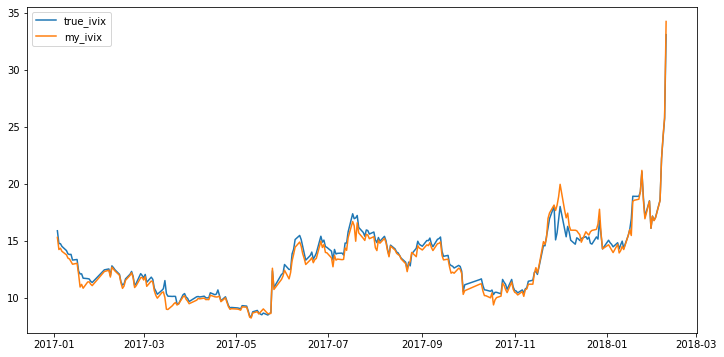

In [95]:
df = pd.merge(true_ivix[['date','true_ivix']],my_ivix)
df['year'] = df['date'].apply(lambda x:x.year)
df = df[df['year']>2016].reset_index(drop=True)
fig = plt.figure(figsize=(12,6))
plt.plot(df['date'],df['true_ivix'])
plt.plot(df['date'],df['ivix'])
plt.legend(['true_ivix','my_ivix'])

在2017年到2018年2月期间，计算结果与真实IVIX非常接近；而2017年以前似乎一直比真实IVIX低3%-4%，不知道为啥。。。

# 后续分析

In [3]:
df1 = pd.read_csv("c://users//coolgan//desktop//my_ivix.csv")
df2 = pd.read_csv("c://users//coolgan//desktop//my_ivix_new.csv")
df3 = pd.read_csv("c://users//coolgan//desktop//my_ivix_new2.csv")
df4 = pd.read_csv("c://users//coolgan//desktop//my_ivix_new3.csv")
true_ivix = pd.read_csv("c://users//coolgan//desktop//ivixx.csv",encoding="GBK")

In [4]:
df = pd.DataFrame()
df = pd.concat([df1,df2,df3,df4]).reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df = df.drop_duplicates('date',keep='last')
df = df[df['ivix']!=df['ivix'].max()].reset_index(drop=True)
df = df[df['ivix']!=df['ivix'].max()].reset_index(drop=True)
# df.to_csv("c://users//coolgan//desktop//temp.csv",index=False,encoding="utf_8_sig")

## 2015年2月10日到2021年4月30日IVIX的走势图

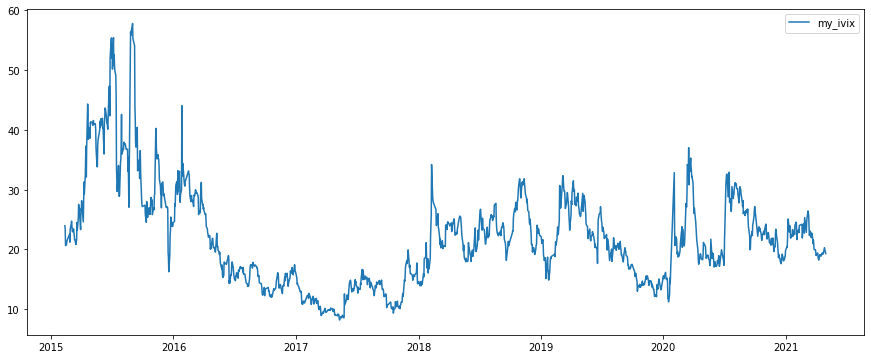

In [5]:
fig = plt.figure(figsize=(15,6))
plt.plot(df['date'],df['ivix'])
plt.legend(['my_ivix'])

与上海纽约大学波动率研究所公布的IVIX计算结果走势一致，数值大小可能有所差异

链接：https://mp.weixin.qq.com/s/oNeN4DZWRmG_ZdQg8e9wQA

## 分析波动率风险溢酬

In [19]:
etf1 = pro.fund_daily(ts_code='510050.SH',start_date = '20180501',end_date = '20210501')
etf2 = pro.fund_daily(ts_code='510050.SH',start_date = '20150210',end_date = '20180501')
etf = pd.concat([etf1,etf2]).drop_duplicates().sort_values(by=['trade_date']).reset_index(drop=True)
etf['date'] = pd.to_datetime(etf['trade_date'])

In [169]:
data = pd.merge(df,etf[['date','close']])
data['ret'] = data['close'].pct_change()*100
data['rv']= np.sqrt((data['ret']**2).rolling(30).sum()*240/30)
data['vrp'] = data['rv'] - data['ivix']
data = data[(data['trade_date']>20150416)].reset_index(drop=True)
#data.to_csv("c://users//coolgan//desktop//data_merge.csv",index=False,encoding="utf_8_sig")

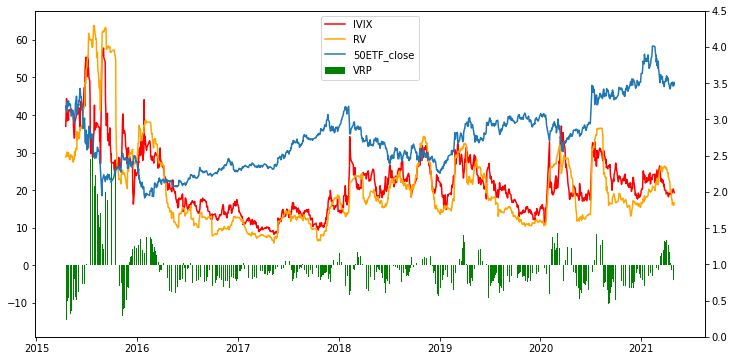

In [170]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
fig1 = ax.plot(data['date'],data['ivix'],'red')
fig_11 = ax.plot(data['date'],data['rv'],'orange')
fig_111 = ax.bar(data['date'],data['vrp'],color='green',label='VRP')
ax2 = ax.twinx()
fig2 = ax2.plot(data['date'],data['close'])
ax2.set_ylim([0,4.5])
ax.legend(fig1+fig_11+fig2+[fig_111],['IVIX','RV','50ETF_close','VRP'],loc=9)

VRP总体小于零，且IVIX与50ETF收盘价正相关，与郑振龙和秦明（2018）的结论基本一致。

参考文献：郑振龙, 秦明, 隐含波动率与实际波动率的关系：中美比较. \[J\] 管理科学, 2018.

# 下面都是草稿。。。

In [ ]:
trade_date = '20191223'
interp = get_rf(trade_date)
opt_near,opt_2near = opt_data(trade_date)

In [ ]:
opt_price = pro.opt_daily(trade_date=trade_date,exchange="SSE")
opt_price_temp = opt_price[opt_price['exchange'] == 'SSE'].reset_index(drop=True)
opt_basic_temp = opt_basic[opt_basic['ts_code'].isin(opt_price_temp['ts_code'])][
    ['ts_code','call_put','maturity_date','exercise_price']
].reset_index(drop=True)

# opt_price = pd.merge(opt_price_temp,opt_basic_temp)
# opt_price['tau'] = (pd.to_datetime(opt_price['maturity_date']) - pd.to_datetime(opt_price['trade_date'])).apply(lambda x:x.days)
# opt_price = opt_price.sort_values(by=['tau','exercise_price']).reset_index(drop=True)

In [ ]:
opt_df = opt_near

opt_df_call = opt_df[opt_df['call_put'] == "C"].sort_values(by=['exercise_price']).reset_index(drop=True)
opt_df_put = opt_df[opt_df['call_put'] == "P"].sort_values(by=['exercise_price']).reset_index(drop=True)

opt_df_call = opt_df_call[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'call_close'})
opt_df_put = opt_df_put[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'put_close'})

opt_df_merge = pd.merge(opt_df_call,opt_df_put,on=['tau','exercise_price'])
opt_df_merge['diff_close'] = abs(opt_df_merge['call_close'] - opt_df_merge['put_close'])
S = opt_df_merge[opt_df_merge['diff_close'] == opt_df_merge['diff_close'].min()]['exercise_price'].iloc[0]

tau = opt_df_merge['tau'].unique().tolist()[0]
opt_df_merge['R'] = interp(tau)/100
opt_df_merge['F'] = S + np.exp( opt_df_merge['R'] * (tau/365) )*(opt_df_merge[opt_df_merge['exercise_price'] == S]['call_close'] - opt_df_merge[opt_df_merge['exercise_price'] == S]['put_close']).iloc[0]#.mean()
opt_df_merge['F - Ki'] = opt_df_merge['F'] - opt_df_merge['exercise_price']
try:
    opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'][opt_df_merge['F - Ki']>0].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]
except Exception:
    opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]
opt_df_merge['PK'] = opt_df_merge.apply(lambda row: row['call_close'] if row['exercise_price']>row['K0'] else (row['put_close'] if row['exercise_price']<row['K0'] else (row['call_close']+row['put_close'])/2 ),axis=1)
opt_df_merge['K_i+1'] = opt_df_merge['exercise_price'].shift(-1).fillna(opt_df_merge['exercise_price'].iloc[-1])
opt_df_merge['K_i-1'] = opt_df_merge['exercise_price'].shift(1).fillna(opt_df_merge['exercise_price'].iloc[0])
opt_df_merge['delta_K'] = (opt_df_merge['K_i+1'] - opt_df_merge['K_i-1'])/2
# opt_df_merge = opt_df_merge.dropna().reset_index(drop=True)

In [ ]:
opt_df_merge['sigma'] = 2/(opt_df_merge['tau']/365)*(opt_df_merge['delta_K']/opt_df_merge['exercise_price']**2)*np.exp(opt_df_merge['R']*opt_df_merge['tau']/365)*opt_df_merge['PK']
sigma = opt_df_merge['sigma'].sum() - (1/(opt_df_merge['tau']/365)*((opt_df_merge['F']/opt_df_merge['K0']-1)**2)).iloc[0]
sigma

In [ ]:
tau1 = opt_near['tau'].unique().tolist()[0]/365
tau2 = opt_2near['tau'].unique().tolist()[0]/365
ivix = np.sqrt((tau1*cal_sigma(opt_near)*((tau2 - 30/365)/(tau2 - tau1)) + \
                tau2*cal_sigma(opt_2near)*((30/365 - tau1)/(tau2 - tau1))) * 365/30)
ivix